# Introduction to Deep Learning  
## Image Captioning Application

#### Author: Alexandre de Carvalho Assunção  
#### ID: 2010074240

In this project, I will implement an encoder-decoder model to generate image captions. The entire project is contained within this notebook, except for the `kaggle.json` file required to access the dataset, which will be uploaded alongside this notebook. The notebook is organized as follows:

1. **Prologue**: Import necessary libraries and load and visualize the Flickr8k dataset.
2. **Dataset**: Format the dataset, applying the necessary transformations to use it as input to a PyTorch model.
3. **Model**: Build the model, explaining my architectural choices.
4. **Training**: Outline the methodology used for training the model.
5. **Results**: Present and discuss the results, including strengths, weaknesses, and suggestions for improvements.
6..**Conclusion**: Discussion of the model's results.

## 1- Prologue

#### 1.1- Imports

Well, deep learning projects tend to sligtly more complex than your average "hello world" code, and doing every single thing from scracth would even the most enthusiastic codes nightmares. So we import libraries. This cell started out with four lines when I first started the project, but as I moved forward more and more packages became necessary. But the main highlights here are the tokenizer, the models, the optimizer, and the function to split the data into train/val/test sets.

On a quick note, I wish to comment that the PIL and IPython.display libraries conflict with each other. IPython was only use to display stuff that wasn't properly rendered by the markdown's cells. The notebook should run smoothly with it commented.

In [ ]:
import os
from transformers import BertTokenizer
from torchvision import transforms
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

#%pip install torchsummary
from torchsummary import summary

from PIL import Image
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from nltk.translate.bleu_score import corpus_bleu

#from IPython.display import Image, display

Broadly speaking, this model represents a relatively simple neural network compared to modern deep learning applications, containing only a few million parameters, some of which are pre-trained. However, even a few *million* parameters are significant and should not be underestimated. Fortunately, the mathematical operations behind forward passes and backpropagation are highly parallelizable, allowing us to leverage GPUs for efficient computation. The cell below ensures that we are connected to an environment equipped with a GPU...or warn you when you're not.


In [ ]:
# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids= list(range(n))

print(device)

cuda


#### 1.2- The dataset

TSelecting the right dataset is one of the most fundamental decisions when training a model. Fortunately, it’s not a particularly difficult one: a good rule of thumb is to pick the largest dataset your hardware can handle. More data typically leads to better results—this could practically be a machine learning proverb.

Given that my PC struggles with games from a decade ago, collab pro is expensive and my credit card could double as a bright yellow women repelent, I opted for the modest Flickr8k dataset, available for free on Kaggle. As we'll see later, it was sufficient for this project.

The Flickr8k dataset contains approximately 8,000 images, along with a text file that provides five captions for each image. In the next three cells, I’ll download the dataset, open it, and load it into a Python dictionary where the keys are image IDs and the values are lists of five captions. After that, I’ll pass the captions through a tokenizer. A tokenizer converts a human-readable string into an array that has semantic meaning for a computer. There are many approaches to building a tokenizer; for this project, I chose the pre-trained BERT tokenizer for its versatility and ease of use.

In [ ]:
from google.colab import files
import zipfile

# Upload kaggle.json
files.upload()

# Set Up Kaggle API
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Flickr8k Dataset
!kaggle datasets download -d adityajn105/flickr8k

# Unziping dataset
with zipfile.ZipFile('flickr8k.zip', 'r') as zip_ref:
    zip_ref.extractall('flickr8k')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.02G/1.04G [00:08<00:00, 173MB/s]
100% 1.04G/1.04G [00:08<00:00, 138MB/s]


In [ ]:
# Path to the images folder
images_folder_path = '/content/flickr8k/Images/'

# List all files in the images folder
image_files = os.listdir(images_folder_path)

# Filter out only files that are images so we don't run into missing images issues.
image_files = [file for file in image_files if file.endswith(('.jpg', '.jpeg', '.png'))]

# Print the number of images
print(f"Number of images in the folder: {len(image_files)}")

Number of images in the folder: 8091


In [ ]:
captions_dict = {}  # key: image_id; values: list of five captions for that image.

with open('/content/flickr8k/captions.txt', 'r') as captions_file:

    for line in captions_file:

        # Split line into image ID and caption
        img_id, caption = line.strip().split(',', 1)

        # Skip if image ID is not in the available image files
        if img_id not in image_files:
            continue

        # Initialize the list for this image ID
        if img_id not in captions_dict:
            captions_dict[img_id] = []

        # Add the caption if there are fewer than 5
        if len(captions_dict[img_id]) < 5:
            captions_dict[img_id].append(caption)


# Print the first three items
for idx, (image_id, captions) in enumerate(captions_dict.items()):
    if idx < 3:
        print(f'Image ID: {image_id}')
        for caption in captions:
            print(f'\t{caption}')
    else:
        break

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_captions_dict = {}

# Tokenize every captions in cations_dict
for image_id, captions in captions_dict.items():
    # Tokenize each caption in the list
    tokenized_captions = [tokenizer.encode(
        caption,
        add_special_tokens=True,
        max_length=50,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ) for caption in captions]

    # Store the tokenized captions in the dictionary
    tokenized_captions_dict[image_id] = tokenized_captions

Image ID: 1000268201_693b08cb0e.jpg
	A child in a pink dress is climbing up a set of stairs in an entry way .
	A girl going into a wooden building .
	A little girl climbing into a wooden playhouse .
	A little girl climbing the stairs to her playhouse .
	A little girl in a pink dress going into a wooden cabin .
Image ID: 1001773457_577c3a7d70.jpg
	A black dog and a spotted dog are fighting
	A black dog and a tri-colored dog playing with each other on the road .
	A black dog and a white dog with brown spots are staring at each other in the street .
	Two dogs of different breeds looking at each other on the road .
	Two dogs on pavement moving toward each other .
Image ID: 1002674143_1b742ab4b8.jpg
	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
	A little girl is sitting in front of a large painted rainbow .
	A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
	There is a girl with pigtails sittin

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Processing the Dataset

Currently, we have a Python dictionary with strings containing image IDs as keys and lists of five captions as values. However, PyTorch can’t directly work with this format—the framework requires the dataset to be an extension of the base `Dataset` class, where we override the `__init__`, `__len__`, and `__getitem__` methods to suit our model’s input requirements.

The functionalities of the `__init__` and `__len__` methods should be straightforward from the code. The key method worth discussing here is `__getitem__`. This method applies the necessary transformations to prepare the images for the ResNet50 network (which we'll discuss in more detail later) and also selects one of the five captions at random for each image.


In [ ]:
class Flickr8kDataset(Dataset):

    def __init__(self, images_folder, tokenized_captions, transform=None):
        self.images_folder = images_folder                # Path to the images folder
        self.tokenized_captions = tokenized_captions      # The img_id to the encoded captions dict
        self.transform = transform                        # Reshape the image to work with ResNet50

    def __len__(self):
        return len(self.tokenized_captions)

    def __getitem__(self, idx):
        image_id = list(self.tokenized_captions.keys())[idx]
        image_path = os.path.join(self.images_folder, f'{image_id}')
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        tokenized_caption = random.choice(self.tokenized_captions[image_id])

        return image, tokenized_caption, image_id

With the dataset loaded, what’s next? Image-captioning, as approached in this project, falls under supervised learning: we feed our model some data and then evaluate its performance on unseen data. Given my lack of experience, I decided to follow ChatGPT’s advice and the guidelines from this course’s previous notebook by making an 80/20 split between the training and test sets. It's worth noting that a portion of the training set will be reserved for cross-validation, but we’ll delve into that when we discuss the training process. I hope the comments in the code and the debugging "prints" at the cel''s end can clarify each step in loading/splitting our data.

In [ ]:
# Extract image IDs from captions_dict
img_ids = list(tokenized_captions_dict.keys())

print(f'Total Number of Images: {len(img_ids)}')

# Pre-process the images to get them ready for our encoder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Split image IDs into training and testing sets
train_ids, test_ids = train_test_split(img_ids, test_size=0.2, random_state=42)

# Create datasets for training and testing
train_captions = {k: tokenized_captions_dict[k] for k in train_ids}
test_captions = {k: tokenized_captions_dict[k] for k in test_ids}

# Create Dataset objects
train_dataset = Flickr8kDataset(images_folder_path, train_captions, transform=transform)
test_dataset = Flickr8kDataset(images_folder_path, test_captions, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Check if everything is okay
print(f"Number of training images: {len(train_loader.dataset)}")
print(f"Number of test images: {len(test_loader.dataset)}")
for image, caption, _ in train_loader:
    print(f'Image: {type(image)}, shape: {image.shape}')
    print(f'Caption: {type(caption)}, shape: {caption.shape}')
    break

Total Number of Images: 8091
Number of training images: 6472
Number of test images: 1619
Image: <class 'torch.Tensor'>, shape: torch.Size([32, 3, 224, 224])
Caption: <class 'torch.Tensor'>, shape: torch.Size([32, 1, 50])


# 3- The Model

The model for an image captioning will always have two components: a) an encoder, which will take images and turn them into numerical representation that, if God likes you, will capture complex, relevant features of the input image; b) a decoder: the decoder will receive the image's features produced by the encoder and the correct caption for that particular image. It will then try to generate its own caption.

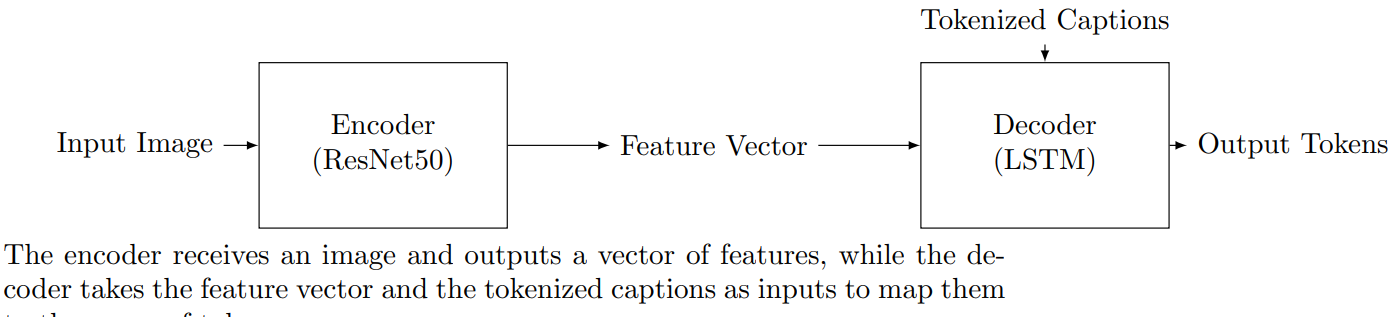

In [ ]:
display(Image(filename='enc.png'))

### 3.1 - The Encoder

I chose the ResNet50 model, with its 50 layers, as an encoder because it is deep network that comes prepared to face the challenges that arise when we get deep. ResNet50 is a CNN with ReLU activations that uses the following three strategies to improve its performance:residual learning, batch normalization, and id blocks. I'll discuss the three below.

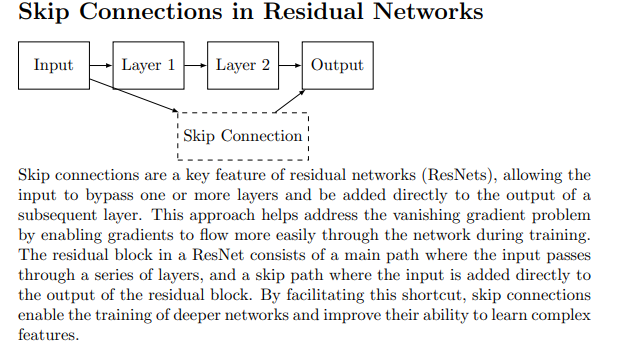

In [ ]:
display(Image(filename='skip.png'))

Batch normalization is a technique used to improve the training speed and stability of neural networks. It normalizes the output of a previous activation layer by adjusting and scaling the activations. This normalization process helps mitigate internal covariate shift and reduces the problem of vanishing/exploding gradients.

The identity block is a type of residual block. It has a main path where the input is processed through several layers, and an identity skip connection that adds the original input to the output of the main path. This design allows for the preservation of the original input while still benefiting from deeper network layers.

The cell below downloads the ResNet50 model, allows for it to be fine tuned, and prints a model summary so we can know the dimensions of each layer's input/output and the number of parameters that we will be fine-tuning when we train the full encoder/decoder model.

In [ ]:
# Loads RestNet50
resnet = models.resnet50(pretrained=True)

# 2. Remove the final fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Unfreeze by setting requires_grad=True for layers to fine-tune it
for param in resnet.parameters():
    param.requires_grad = True

resnet = resnet.to(device)
summary(resnet, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### 3.2 - The Decoder

The decoder will be a special type of RNN called an LSTM (Long Short-Term Memory). LSTMs are better than traditional RNNs when it comes to dealing with long-term dependencies. RNNs lack a mechanism for explicit memory. Each hidden state calculates its output and passes it on, whereas LSTMs use gates to keep or discard information. By being able to control what information is retained or discarded, LSTMs mitigate the exploding/vanishing gradient problem common in RNNs.

The key feature of LSTMs is their ability to handle both short-term and long-term dependencies. They use two different mechanisms: one for short-term memory (i.e., information from the immediately previous state, `h_{t-1} -> h_t`) and one for long-term memory (i.e., information from further back in the sequence, `h_{t-k} -> h_t` for `k > 1`).

To manage vanishing/exploding gradients, the long-term memory part of an LSTM cell does not have parameters and allows the memory to flow forward in time. The short-term memory, on the other hand, has weights and operates similarly to the output of an RNN's hidden unit. In a way, the long-term memory in LSTMs is akin to residual connections, allowing old information to reach distant states.

Here are the key components of an LSTM:

1. **Forget Gate**: The forget gate uses a sigmoid activation function to determine how much of the previous cell state (short-term memory) should be retained. The naming can be confusing, as the forget gate actually determines how much of the previous state to remember, not to forget.

   The forget gate calculation is:
   `f_t = σ(W_f [h_{t-1}, x_t] + b_f)`

2. **Input Gate**: This gate consists of two parts:
   - **Potential Long-Term Memory**: Created by combining the current input `x_t` (e.g., image features) with the previous hidden state `h_{t-1}`. This combination is passed through a tanh function to generate candidate values for the cell state.

     The potential long-term memory calculation is:
     `C̃_t = tanh(W_C [h_{t-1}, x_t] + b_C)`

   - **Input Gate**: Uses a sigmoid function to decide how much of the potential long-term memory should be added to the cell state.

     The input gate calculation is:
     `i_t = σ(W_i [h_{t-1}, x_t] + b_i)`

3. **Output Gate**: This gate determines how much of the cell state will be output as the hidden state. It involves two steps:
   - **Potential Short-Term Memory**: Calculated using a tanh function on the cell state.
   - **Output Gate Calculation**: Uses a sigmoid function to decide how much of this potential short-term memory will be passed to the output.

     The output gate calculation is:
     `o_t = σ(W_o [h_{t-1}, x_t] + b_o)`
     `h_t = o_t ⊙ tanh(C_t)`

In summary, LSTMs use gates to manage and preserve both short-term and long-term dependencies in sequential data. The forget gate controls the retention of past information, the input gate manages the integration of new information, and the output gate determines the contribution of the cell state to the output.

I apologize for the equations' poor formatting. I'm having trouble getting my notebook to render them. However, I hope the diadrams below help understand an LSTM unit clearly.



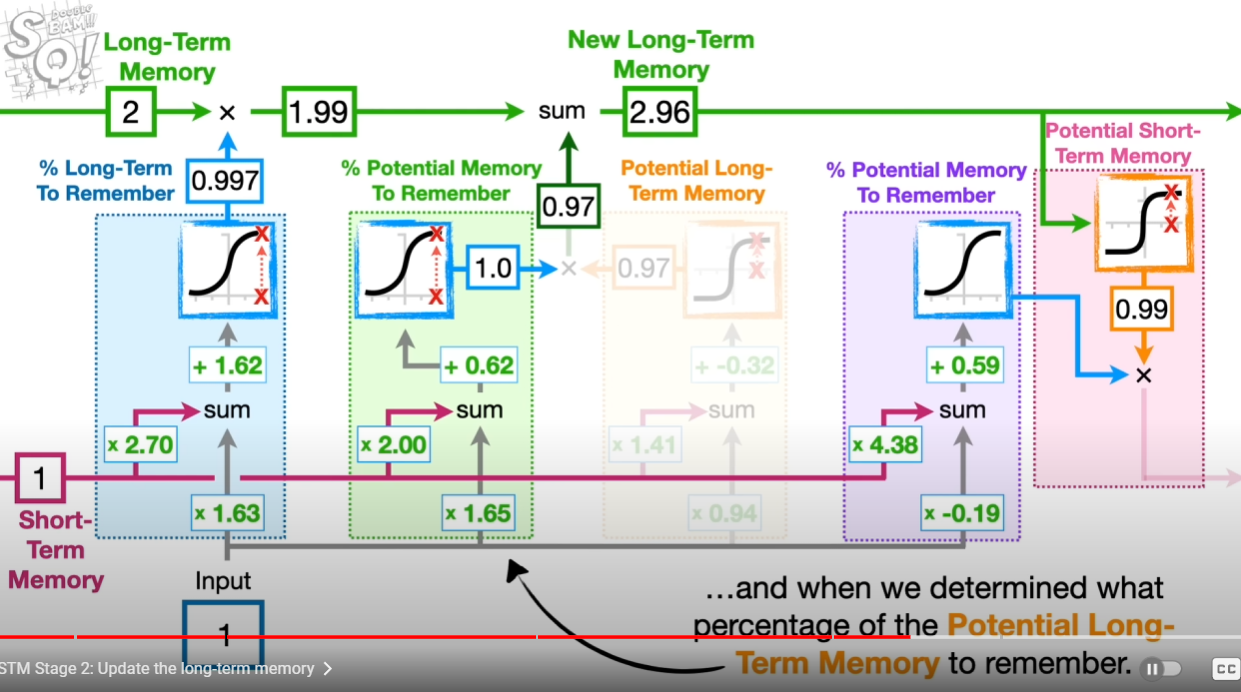

In [ ]:
display(Image(filename='LSTM.png'))

The diagram above is a print screen from StatQuest's video on LSTM, which is the material I use to learn this particular architecture. I highly recommend anyone intrested in neural nets or just machine learning in general to check out his channel, linked below.

https://www.youtube.com/@statquest

In [ ]:
# Defines a LSTM model
class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=4, dropout_prob=0.5):
        super(LSTMDecoder, self).__init__()
        # Embedding layer for the captions
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim + 2048, hidden_dim, num_layers,
                            batch_first=True,
                            dropout=dropout_prob if num_layers > 1 else 0)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, image_features, captions):
        # Pass captions through embedding layer
        embedded_captions = self.embedding(captions)

        # Get the batch size and sequence length
        batch_size, _, seq_len = captions.shape

        # Expand image features to match the sequence length
        image_features = image_features.unsqueeze(1).repeat(1, seq_len, 1)

        # Fix dimensions of embedded_captions
        embedded_captions = embedded_captions.squeeze(1)  # Remove the extra dimension [batch_size, seq_len, embedding_dim]

        #print("Before LSTM forward:")
        #print(f" Image Shape: {image_features.shape}")
        #print(f" Emb Captions Shape: {embedded_captions.shape}")

        # Concatenate the image features and the embedded captions
        lstm_input = torch.cat((image_features, embedded_captions), dim=2)

        #print(f" Concat Input: {lstm_input.shape}")

        # Pass through LSTM
        lstm_out, _ = self.lstm(lstm_input)

        # Pass through fully connected layer
        output = self.fc(lstm_out)

        return output

### 3.3- The full network

Now we're ready to integrate everything. We start by passing the image through the encoder to obtain a feature vector. This feature vector, along with the tokenized captions, is then fed into the decoder. The first layer of the decoder is an embedding layer, significantly reducing the dimensionality of tekens' space while capture relevant correlations between the tokens. With this setup, we can train a complete image-to-text model. My mom was *very* impressed with the results.

"It's like magic!" she said. "You're so smart!"


In [ ]:
# Implementing the full Encoder/Decoder model
class ImageCaptioningModel(nn.Module):
    def __init__(self, resnet, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=4, dropout_prob=0.5):
        super(ImageCaptioningModel, self).__init__()
        self.resnet = resnet
        self.lstm_decoder = LSTMDecoder(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_prob)

    def forward(self, images, captions):
        # Extract features from images using ResNet
        with torch.no_grad():
            image_features = self.resnet(images)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten the features

        # Pass image features and captions to the LSTM decoder
        outputs = self.lstm_decoder(image_features, captions)
        return outputs


Below is a simple pseudocode for the image-to-text model. During the training process, we will use batches of images and captions instead of processing single images at a time.

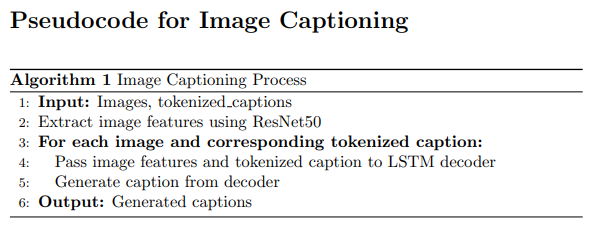

In [ ]:
display(Image(filename='model_pseudocode.png'))

Below follows a simplified diagram of the full model. In the final version of the model I used four LSTM layers following the embedding layer of the decoder.

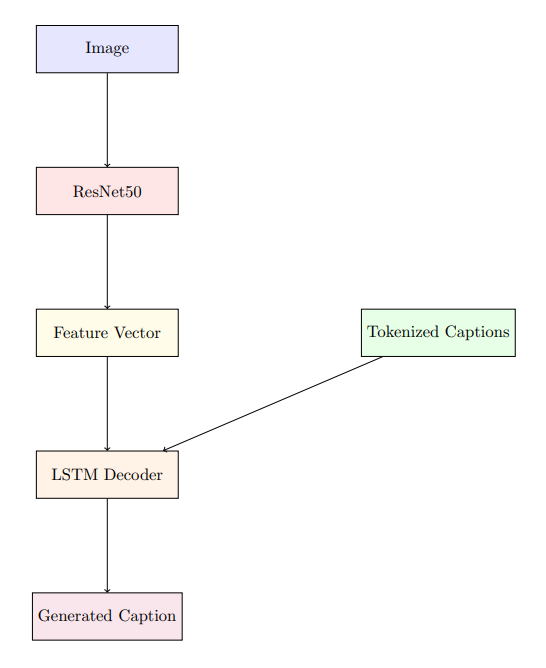

In [ ]:
display(Image(filename='full_model_diagram.png'))

## 4- Training

To train the model, we divided our data into two sets: the training set and the validation set. This separation allows us to fine-tune hyperparameters effectively and assess whether our model is underfitting or overfitting.

For this model, I employed 5-fold cross-validation. The embedding dimension was set to 512, balancing between generalization capability and computational resources. Each LSTM unit was configured with 512 hidden neurons. The learning rate was chosen as 0.0005, and the batch size was set to 32, which is the maximum I can use without risking memory overflow.

The model was trained over 25 epochs. In the results section, we will see that simply increasing the number of epochs without implementing additional strategies, such as data augmentation or further regularization (beyond dropout), tends to lead to overfitting.

I opted to use the Adam optimizer, a popular choice in deep learning due to its adaptive learning rate properties. Adam combines the advantages of two other extensions of stochastic gradient descent, namely AdaGrad and RMSProp. It adjusts the learning rate of each parameter individually, which helps in navigating complex optimization landscapes more effectively. This adaptability is particularly useful in training models with many parameters, as it leads to faster convergence and more robust performance across different tasks.

In [ ]:
## ****************************************************** ##
##                                                        ##
##                    THE TRAINING LOOP                   ##
##                                                        ##
## ****************************************************** ##

# Fixed Parameters:
vocab_size = 30522  # Defined by BERT's tokenizer
output_dim = 30522  # Defined by BERT's tokenizer

# Tunable Parameters:
num_folds = 5
num_layers = 4
seq_len = 50
embedding_dim = 512
hidden_dim = 512
num_epochs = 25
learning_rate = 0.0005
batch_size = 32

# Prepare data splits
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# Track results across folds
fold_results = []


for fold, (train_indices, val_indices) in enumerate(kf.split(range(len(train_dataset)))):

    print(f"Fold {fold + 1}/{num_folds}")

    # Create train and validation datasets
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler)

    # Building the model
    model = ImageCaptioningModel(resnet, vocab_size, embedding_dim, hidden_dim, output_dim)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        # -------------------------------------------------------------------- #
        #                          TRAINING                                    #
        # -------------------------------------------------------------------- #
        model.train()
        running_loss = 0.0

        for images, captions, _ in train_loader:

            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions)

            # Reshape for CrossEntropyLoss
            batch_size, seq_len, vocab_size = outputs.size()
            outputs = outputs.view(-1, vocab_size)  # Shape: (batch_size * seq_len, vocab_size)
            captions = captions.view(-1)            # Shape: (batch_size * seq_len)

            # Calculate loss
            loss = criterion(outputs, captions)
            running_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / len(train_loader)
        print(f'  Epoch [{epoch + 1}/{num_epochs}]')
        print(f'      Training Loss: {epoch_loss}')
        train_losses.append(epoch_loss)

        # -------------------------------------------------------------------- #
        #                          VALIDATING                                  #
        # -------------------------------------------------------------------- #
        model.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            for images, captions, _ in val_loader:

                images = images.to(device)
                captions = captions.to(device)

                # Forward pass
                outputs = model(images, captions)

                # Reshape for CrossEntropyLoss
                batch_size, seq_len, vocab_size = outputs.size()
                outputs = outputs.view(-1, vocab_size)  # Shape: (batch_size * seq_len, vocab_size)
                captions = captions.view(-1)            # Shape: (batch_size * seq_len)

                # Calculate loss
                loss = criterion(outputs, captions)
                val_running_loss += loss.item()

            val_loss = val_running_loss / len(val_loader)
            print(f'      Validation Loss: {val_loss}')
            val_losses.append(val_loss)

    fold_results.append({
        'fold': fold + 1,
        'train_losses': train_losses,
        'val_losses': val_losses
    })

# Saving the parameters so we don't have to retrain the model to sample from it later.
torch.save(model.state_dict(), 'image_caption_parameters.pth')

Fold 1/5
  Epoch [1/25]
      Training Loss: 2.2978475432337064
      Validation Loss: 1.64308855010242
  Epoch [2/25]
      Training Loss: 1.4757219199781064
      Validation Loss: 1.3440162815698764
  Epoch [3/25]
      Training Loss: 1.290642668435603
      Validation Loss: 1.2675022177579927
  Epoch [4/25]
      Training Loss: 1.1687504045757247
      Validation Loss: 1.0924921253832376
  Epoch [5/25]
      Training Loss: 1.0337036395514454
      Validation Loss: 0.9743774620498099
  Epoch [6/25]
      Training Loss: 0.9429547867657225
      Validation Loss: 0.9267322668215123
  Epoch [7/25]
      Training Loss: 0.8779602672582791
      Validation Loss: 0.8438194859318617
  Epoch [8/25]
      Training Loss: 0.82958162235625
      Validation Loss: 0.8114106218989302
  Epoch [9/25]
      Training Loss: 0.7992473410235511
      Validation Loss: 0.7799319872042028
  Epoch [10/25]
      Training Loss: 0.7596974575225218
      Validation Loss: 0.7374806433189206
  Epoch [11/25]
      Tra

## 5- Results

After training the model, it is finally time to check its performance. First, we need to see the behavior of loss functions for the training and validation data across all folds. In the cells blow, I plot the mean loss by epoch for both the training and validation data. The shaded region around the graph's line in the model outputs' standard deviation.

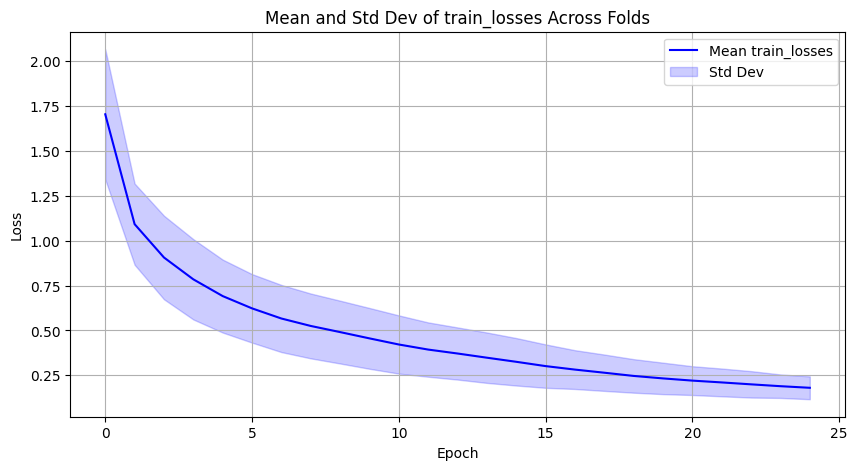

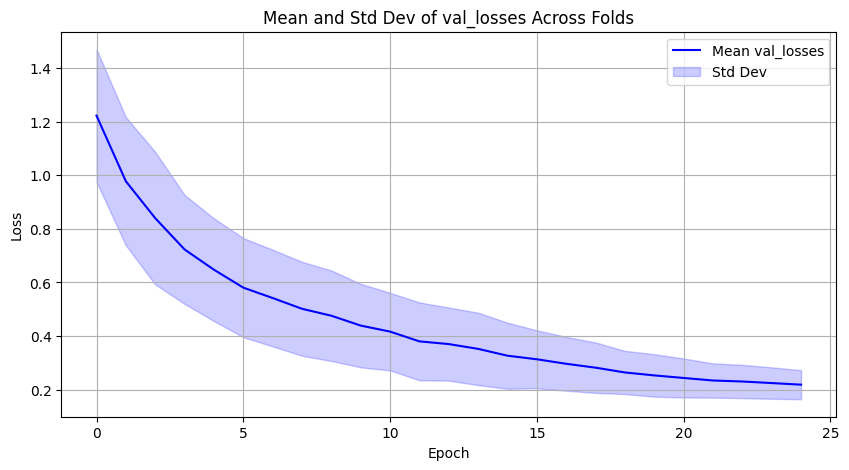

In [ ]:
def plot_mean_stddev(fold_results, loss_type):
    num_folds = len(fold_results)
    num_epochs = len(fold_results[0][loss_type])

    # Initialize arrays to hold sum of losses and squared losses for variance calculation
    mean_losses = np.zeros(num_epochs)
    stddev_losses = np.zeros(num_epochs)

    for result in fold_results:
        train_losses = [np.mean(epoch_losses) for epoch_losses in result[loss_type]]
        mean_losses += np.array(train_losses)
        stddev_losses += np.array(train_losses)**2

    # Compute mean and standard deviation
    mean_losses /= num_folds
    stddev_losses = np.sqrt((stddev_losses / num_folds) - mean_losses**2)

    # Plot mean and standard deviation
    plt.figure(figsize=(10, 5))
    plt.plot(mean_losses, label=f'Mean {loss_type}', color='blue')
    plt.fill_between(range(num_epochs), mean_losses - stddev_losses, mean_losses + stddev_losses, color='blue', alpha=0.2, label='Std Dev')

    plt.title(f'Mean and Std Dev of {loss_type} Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

    return mean_losses

mean_train_losses = plot_mean_stddev(fold_results, 'train_losses')
mean_val_losses = plot_mean_stddev(fold_results, 'val_losses')

Next, we need to compare the training loss with the validation loss. Observe that after the twentieth epoch, the validation loss appears to plateau and remains higher than the training loss. This plateau is indicative of overfitting: the model has ceased learning the underlying distribution of the data and is now merely memorizing the training examples.

With nore data or additional regularization techniques, we could train the model for more epochs and arrive at better results, but that falls beyond the scope of this project.

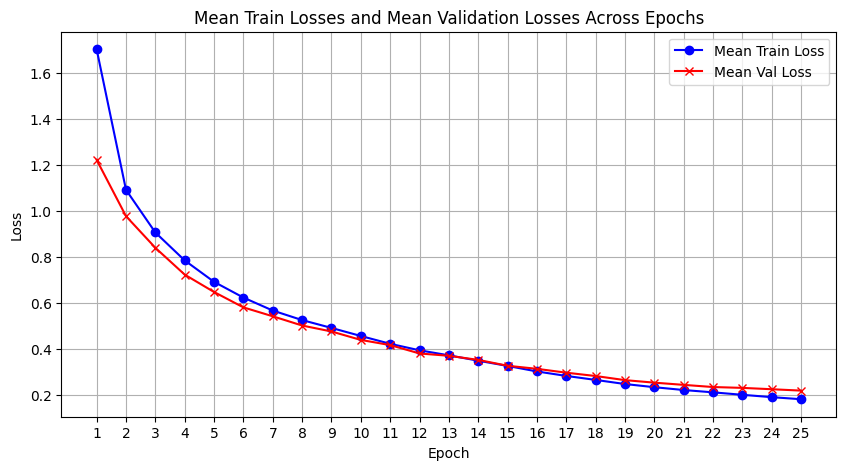

In [ ]:
def plot_train_and_val_losses(mean_train, mean_val):
    epochs = range(1, len(mean_train) + 1)  # X-axis: epochs (1, 2, 3, ...)

    plt.figure(figsize=(10, 5))

    # Plotting mean train losses
    plt.plot(epochs, mean_train, color='blue', marker='o', linestyle='-', label='Mean Train Loss')

    # Plotting mean validation losses
    plt.plot(epochs, mean_val, color='red', marker='x', linestyle='-', label='Mean Val Loss')

    plt.title('Mean Train Losses and Mean Validation Losses Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Ensure x-axis shows all epochs
    plt.grid(True)
    plt.legend()
    plt.show()

plot_train_and_val_losses(mean_train_losses, mean_val_losses)

Finally, it's time to have a little fun. Let's sample images from the test data, which we created way back in section 2 of this notebook, and let's see what the model gives us!

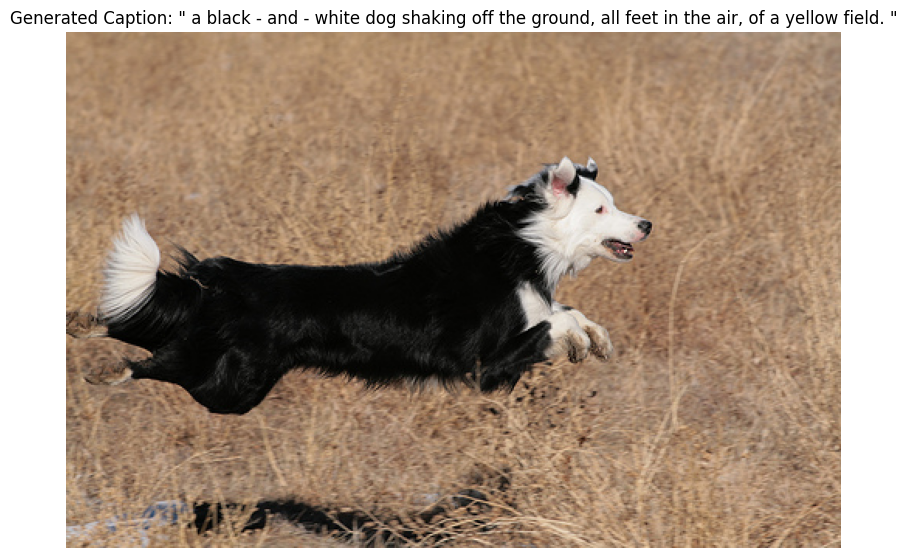

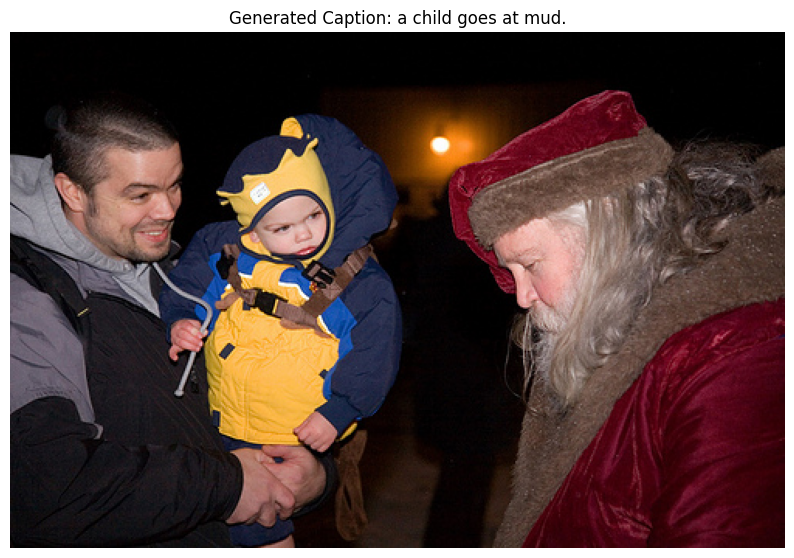

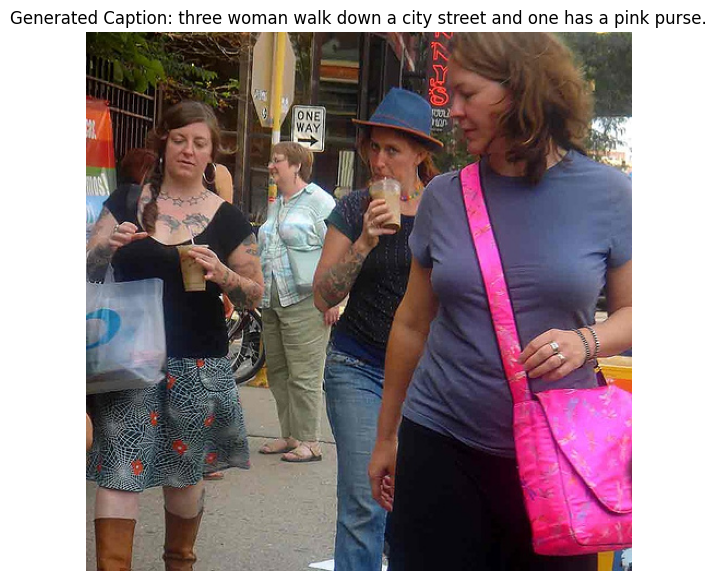

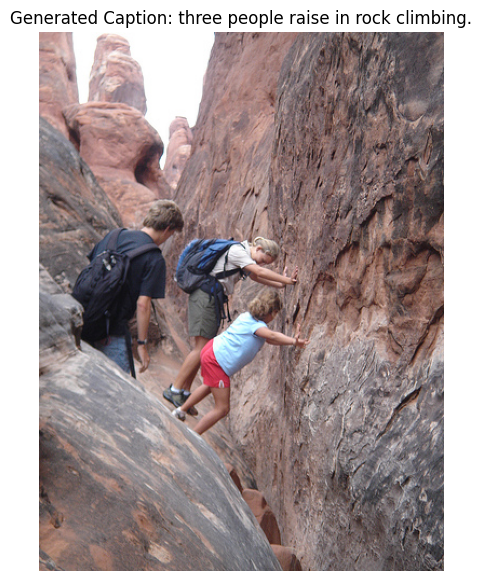

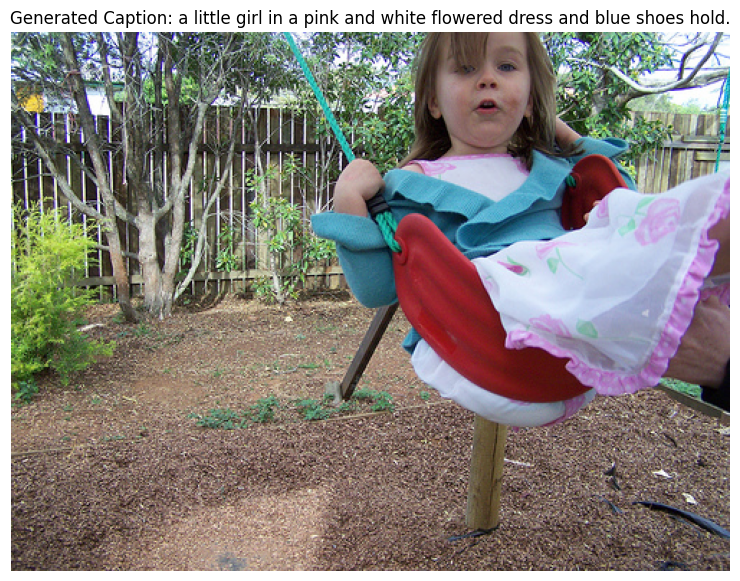

In [ ]:
# Generate captions for a batch of images
def sample_captions(model, data_loader, device, tokenizer, n=5):
    model.eval()
    images_folder = '/content/flickr8k/Images/'
    num_displayed = 0  # To track how many images have been displayed

    with torch.no_grad():
        for images, captions, img_ids in data_loader:
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions)

            # Decode generated captions
            batch_size, seq_len, vocab_size = outputs.size()
            predicted_idx = torch.argmax(outputs, dim=-1)
            predicted_tokens = predicted_idx.tolist()

            for tokens, img_id in zip(predicted_tokens, img_ids):
                caption = tokenizer.decode(tokens, skip_special_tokens=True)

                # Load and display the image
                image_path = os.path.join(images_folder, f'{img_id}')  # Assuming jpg format, adjust if necessary
                img = Image.open(image_path).convert('RGB')
                img = img.resize((800, 600))

                # Display the image and captions
                plt.figure(figsize=(10, 7))
                plt.imshow(img)
                plt.axis('off')  # Hide axis
                plt.title(f'Generated Caption: {caption}')
                plt.show()

                num_displayed += 1
                if num_displayed >= n:
                    return

sample_captions(model, test_loader, device, tokenizer)

## Conclusion

As we can see above, the model gets *the gist* of the image (with the exception of the mud one; I was personally hoping for something like "Little jester frowns at the court wizard", but it did recognize a kid in there.

Grammatical structure is another area in which the model has room for improvement. We can see sentences ending in verbs and wrong prepositions (no hard feeling on that one, I'm not good at prepositions either).